## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import ConfusionMatrixDisplay

import os
import json
import random

from google.cloud.storage import Client

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

Changed working directory to G:\Other computers\My Laptop\UW\Classes\ESS521\project


### Get example record from GCS

In [2]:
client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="ca_whole_image")
    if ".tfrecord" in f.name
]

random.shuffle(records)

print("\n".join(records))

gs://preisler_tfdata/ca_whole_image/yr2018/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2010/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2003/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2019/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2022/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2000/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2023/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2020/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2005/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2011/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2015/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2014/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2008/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2016/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2007/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2002/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2006/00000.tfrecord
gs://preisler_

In [3]:
from google.protobuf import json_format
from IPython.display import JSON

ds = tf.data.TFRecordDataset(records)

raw_record = next(ds.take(1).as_numpy_iterator())
example = tf.train.Example()
example.ParseFromString(raw_record)
m = json.loads(json_format.MessageToJson(example))
JSON(m)

<IPython.core.display.JSON object>

### Tensor spec
With this data we are working with the (mostly) raw pixels as output by earth engine. So, we don't have to go through the trouble of making a TF Dataset. Instead we can just define the TensorSpec and go straight to preprocessing. Conveniently, everything here has the same shape so we can use the names from the above JSON to make the spec.

In [4]:
m["features"]["feature"].keys()

dict_keys(['year', 'longitude', 'latitude', 'prcp1', 'prcp2', 'prcp3', 'prcp4', 'winter_tmin', 'rhost', 'near', 'fire', 'pct_mortality'])

In [5]:
spec = {
    key: tf.io.FixedLenFeature([1], dtype=tf.int64 if key == "year" else tf.float32)
    for key in m["features"]["feature"].keys()
}

In [6]:
def decode_record(proto):
    return tf.io.parse_single_example(proto, spec)

def empty_record(record):
    return tf.math.count_nonzero(record["longitude"]) > 0

ds_dec = ds.map(decode_record).filter(empty_record)

feature = next(ds_dec.take(1).as_numpy_iterator())

In [7]:
feature

{'fire': array([0.], dtype=float32),
 'latitude': array([42.006813], dtype=float32),
 'longitude': array([-124.16514], dtype=float32),
 'near': array([0.], dtype=float32),
 'pct_mortality': array([0.], dtype=float32),
 'prcp1': array([3606.8503], dtype=float32),
 'prcp2': array([2628.6787], dtype=float32),
 'prcp3': array([2036.879], dtype=float32),
 'prcp4': array([1606.2972], dtype=float32),
 'rhost': array([0.8273447], dtype=float32),
 'winter_tmin': array([-1.6765052], dtype=float32),
 'year': array([2018], dtype=int64)}

### Preprocessing

To match the paper, we have to convert `pct_mortality` to a binary variable. Technically there's another model on top of this one that predicts area affected by mortality given that some mortality is predicted.

In [8]:
def preprocess(feature):
    feature["pct_mortality"] = tf.math.greater(feature["pct_mortality"], 0)

    output = feature.pop("pct_mortality")

    # Example, target, sample weight
    return feature, {"pct_mortality": output}

ds_proc = ds_dec.map(preprocess)

feature = next(ds_proc.take(1).as_numpy_iterator())

In [9]:
feature

({'fire': array([0.], dtype=float32),
  'latitude': array([42.006813], dtype=float32),
  'longitude': array([-124.16514], dtype=float32),
  'near': array([0.], dtype=float32),
  'prcp1': array([3606.8503], dtype=float32),
  'prcp2': array([2628.6787], dtype=float32),
  'prcp3': array([2036.879], dtype=float32),
  'prcp4': array([1606.2972], dtype=float32),
  'rhost': array([0.8273447], dtype=float32),
  'winter_tmin': array([-1.6765052], dtype=float32),
  'year': array([2018], dtype=int64)},
 {'pct_mortality': array([False])})

### Model building

In [10]:
import tensorflow.keras as keras

REG  = keras.regularizers.L1(0.001)
DROP = 0.05
ACT  = "relu"

# print(sorted(list(spec.keys())))

def build_preisler_model():
    # Inputs
    inputs =  [
        keras.layers.Input(shape=(1,), name=key)
        for key in sorted(list(spec.keys())) 
        if key not in ["pct_mortality", "year"]
    ]

    # Concatenate all the inputs together
    concat = keras.layers.Concatenate(axis=1)(inputs)

    # Normalize each parameter independently
    norm = keras.layers.BatchNormalization(axis=1)(concat)

    # Feed normalized data to a few dense layers with dropout
    d1 = keras.layers.Dense(128, activation=ACT)(norm)
    # drop1 = keras.layers.Dropout(DROP)(d1)
    d2 = keras.layers.Dense(16, activation=ACT)(d1)
    # drop2 = keras.layers.Dropout(DROP)(d2)
    d3 = keras.layers.Dense(8, activation=ACT)(d2)

    # Connect to output
    out = keras.layers.Dense(1, activation="sigmoid", name="pct_mortality")(d3)

    return keras.models.Model(inputs=inputs, outputs=out)

model = build_preisler_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fire (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 latitude (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 longitude (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 near (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

### Train-test-validate split

In [11]:
from matplotlib import pyplot as plt
import numpy as np

n_total = 5000
n_train = int(n_total * 0.70)
n_test  = int(n_total * 0.15)
n_valid = int(n_total * 0.15)
batch_size = 256

ds_train = ds_proc.take(n_train).shuffle(100).batch(batch_size)
ds_test  = ds_proc.skip(n_train).take(n_test).shuffle(100).batch(batch_size)
ds_valid = ds_proc.skip(n_train+n_test).take(n_valid).shuffle(100).batch(batch_size)

# Check distribution of response in training data
y_train = [[ex[1]["pct_mortality"].numpy() for ex in ds_train]]
y_train = np.concatenate(y_train[0]).squeeze()

# Regression version
# plt.hist(y_train)
# plt.show()

# Classification version
print("Cells with mortality\t", np.sum(y_train > 0))
print("Cells without mortality\t", np.sum(y_train == 0))

Cells with mortality	 1275
Cells without mortality	 2225


### Model training

In [12]:
# Reset weights
model = build_preisler_model()

# Metric to monitor class imbalance
def pct_positive_cases(y_true, y_pred):
    return tf.math.reduce_mean(y_true)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    metrics=[
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        pct_positive_cases
    ],
    weighted_metrics=[]
)

In [14]:
# Callbacks
earlystop = keras.callbacks.EarlyStopping(monitor="loss", patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("tmp/preisler_model.keras")
logdir = "logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [15]:
history = model.fit(
    x=ds_train,
    validation_data=ds_valid,
    epochs=100,
    verbose=0,
    callbacks=[earlystop, checkpoint, tensorboard_callback]
)

C:\Users\rsgal\miniconda3\envs\gee\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


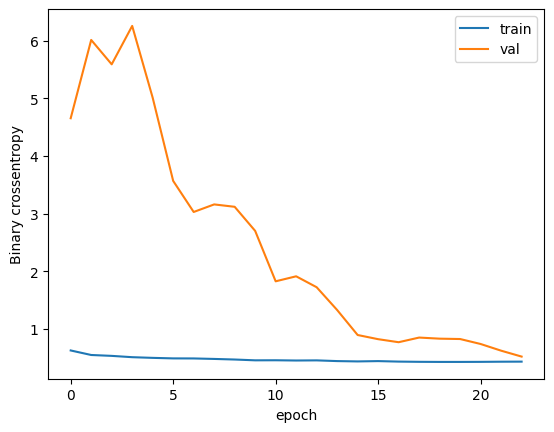

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Binary crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Show fit on training data

14/14 [==============================] - 2s 27ms/step


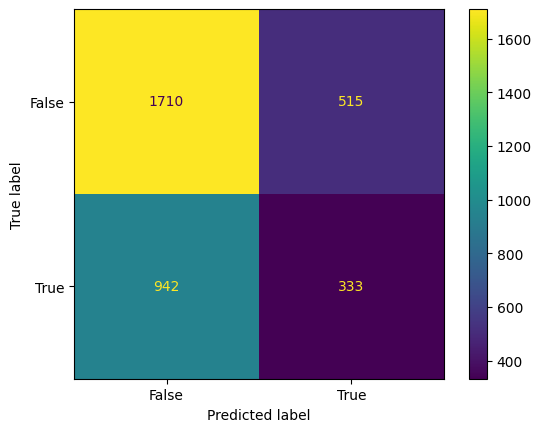

In [18]:
y_train_hat = model.predict(ds_train)
y_train_hat_classif = y_train_hat > 0.5

ConfusionMatrixDisplay.from_predictions(y_train, y_train_hat_classif)
plt.show()

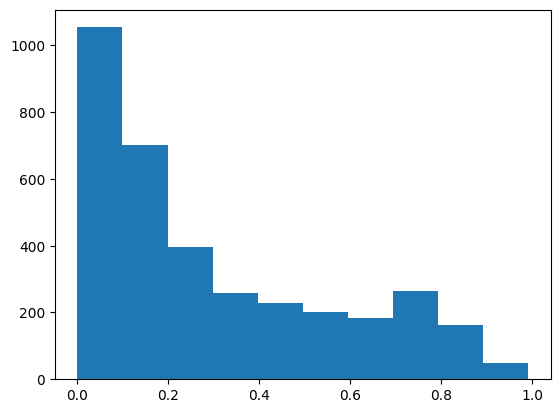

In [19]:
plt.hist(y_train_hat)
plt.show()

### Evaluate on new data

3/3 [==============================] - 2s 29ms/step


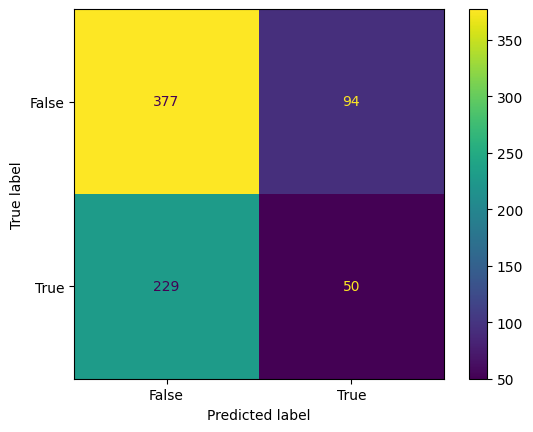

In [20]:
y_test = [[ex[1]["pct_mortality"].numpy() for ex in ds_test]]
y_test = np.concatenate(y_test[0]).squeeze()

y_pred = model.predict(ds_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred > 0.5)
plt.show()

## Version with rectangular data

In [19]:
import pandas as pd
rect = pd.read_csv("gs://preisler_tfdata/preisler-tensors-rectangular.csv")
rect.drop(labels=["system:index", ".geo"], inplace=True, axis=1)
rect.head()

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
0,0.0,39.364372,-120.643743,0.0,0.0,2165.096253,2625.065732,2528.197322,2350.336264,0.997197,-9.364091,2000
1,0.0,38.357131,-120.284417,0.0,0.0,1313.865375,2099.670087,1540.242359,1516.318232,1.000000,-7.670080,2000
2,0.0,37.961582,-119.565764,0.0,0.0,826.657742,1415.066463,1230.405996,1064.524727,0.917275,-12.647418,2000
3,0.0,40.766764,-121.003069,0.0,0.0,776.796833,1317.913046,939.542740,998.941222,0.991734,-14.273738,2000
4,0.0,39.558565,-120.176619,0.0,0.0,815.862638,1034.520669,1020.311838,1014.091595,1.000000,-13.128885,2000


In [20]:
rect.shape

(16428, 12)

If we manually scale the data and use a model without batch normalization, does the model perform better?

In [21]:
# From https://keras.io/examples/timeseries/timeseries_weather_forecasting/
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

rect_norm = normalize(rect.drop("pct_mortality", axis=1))
# Verify that it is properly normalized
rect_norm.describe()

,fire,latitude,longitude,near,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
count,1.642800e+04,1.642800e+04,1.642800e+04,1.642800e+04,1.642800e+04,1.642800e+04,1.642800e+04,1.642800e+04,1.642800e+04,1.642800e+04,1.642800e+04
mean,-1.197898e-14,-2.036901e-13,5.590738e-13,2.119797e-15,-2.149040e-15,-9.238545e-16,-2.609136e-15,-9.327144e-16,-1.514834e-14,1.493915e-16,8.314589e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.206856e-01,-2.575962e+00,-1.817177e+00,-4.930066e-01,-1.562842e+00,-1.572711e+00,-1.663400e+00,-1.667384e+00,-1.508965e+00,-3.830124e+00,-1.958816e+00
25%,-2.206856e-01,-7.297761e-01,-8.950848e-01,-4.930066e-01,-7.605963e-01,-7.500063e-01,-7.696947e-01,-7.755382e-01,-1.182704e+00,-7.761360e-01,-8.170477e-01
50%,-2.206856e-01,2.031942e-01,7.797297e-03,-4.720559e-01,-2.347033e-01,-2.370821e-01,-2.277868e-01,-2.248279e-01,4.491864e-01,1.518011e-01,-1.499243e-03
75%,-2.206856e-01,8.555440e-01,6.801563e-01,-5.304195e-02,5.505130e-01,5.460332e-01,5.811095e-01,5.952271e-01,9.212638e-01,8.539091e-01,8.140492e-01
max,1.005337e+01,1.402949e+00,2.428290e+00,4.744668e+00,6.612845e+00,6.533966e+00,5.067192e+00,5.008829e+00,9.971658e-01,2.094110e+00,1.792707e+00


In [22]:
ACT = "relu"

def build_nobn_model():
    # Same model as before, just without batch normalization
        # Inputs
    inputs =  keras.layers.Input(shape=(11,), name="input")

    # Feed normalized data to a few dense layers
    d1 = keras.layers.Dense(128, activation=ACT)(inputs)
    #d2 = keras.layers.Dense(16, activation=ACT)(d1)
    d3 = keras.layers.Dense(64,  activation=ACT)(d1)

    # Connect to output
    out = keras.layers.Dense(1, activation="sigmoid", name="pct_mortality")(d3)

    return keras.models.Model(inputs=inputs, outputs=out)

model_nobn = build_nobn_model()
model_nobn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 11)]              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1536      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 pct_mortality (Dense)       (None, 1)                 65        
                                                                 
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_nobn.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        pct_positive_cases
    ],
    weighted_metrics=[]
)

In [24]:
X = rect_norm
y = rect["pct_mortality"] > 0

history = model_nobn.fit(
    x=X,
    y=y,
    epochs=10,
    verbose=1
)

Epoch 1/10
514/514 [==============================] - 1s 1ms/step - loss: 0.4958 - precision_1: 0.6905 - recall_1: 0.5004 - auc_1: 0.8112 - pct_positive_cases: 0.3392
Epoch 2/10
514/514 [==============================] - 1s 1ms/step - loss: 0.4610 - precision_1: 0.7010 - recall_1: 0.5945 - auc_1: 0.8397 - pct_positive_cases: 0.3393
Epoch 3/10
514/514 [==============================] - 1s 1ms/step - loss: 0.4482 - precision_1: 0.7110 - recall_1: 0.6174 - auc_1: 0.8499 - pct_positive_cases: 0.3392
Epoch 4/10
514/514 [==============================] - 1s 1ms/step - loss: 0.4402 - precision_1: 0.7168 - recall_1: 0.6253 - auc_1: 0.8555 - pct_positive_cases: 0.3392
Epoch 5/10
514/514 [==============================] - 1s 1ms/step - loss: 0.4342 - precision_1: 0.7224 - recall_1: 0.6356 - auc_1: 0.8599 - pct_positive_cases: 0.3392
Epoch 6/10
514/514 [==============================] - 1s 1ms/step - loss: 0.4285 - precision_1: 0.7255 - recall_1: 0.6436 - auc_1: 0.8641 - pct_positive_cases: 0.339

514/514 [==============================] - 1s 909us/step


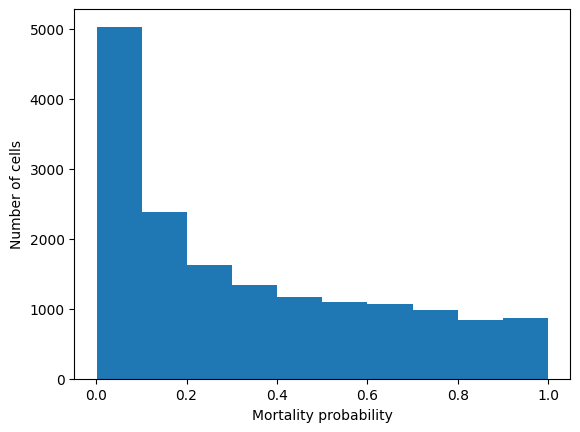

In [25]:
# See distribution of predictions
yhat = model_nobn.predict(X)
plt.hist(yhat)
plt.xlabel("Mortality probability")
plt.ylabel("Number of cells")
plt.show()